# 20 newsgroups classification

Here we use the [20 newsgroups text dataset by Ken Lang](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html), which is a dataset of 20,000 messages from 20 different newsgroups. One thousand messages from each newsgroup were sampled randomly and classified by newsgroup.

The standard GloVe (Global Vectors for Word Representation) word vector model of the Stanford NLP Group is used for this task.

- reference: [*GloVe: Global Vectors for Word Representation*, Empirical Methods in Natural Language Processing (EMNLP), J. Pennington, R. Socher and C. D. Manning (2014)](http://www.aclweb.org/anthology/D14-1162)

```Bash
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip
```

We use this data to train 1D convolutional neural networks in Keras to classify the messages into one of two newsgroup classes.

For the case of one of the models, a dropout probability of 0.1 was applied to convolutional layers in towers and the more standard approach of a dropout probability of 0.5 was applied to the more output dense layer [[ref](https://stats.stackexchange.com/a/317313)].

## references/inspirations

- [reference](https://www.kaggle.com/carlosaguayo/deep-learning-for-text-classification)
- [reference](https://docs.google.com/presentation/d/1NQpJtkD8PhMmER4fw4WO0VwaD9I-s20gWnypwbkx5wk)
- [reference](https://github.com/pavansolapure/opencodez-samples/blob/master/keras-text-classification/20_news_group_classification.py)
- [reference](http://ai.intelligentonlinetools.com/ml/text-classification-20-newsgroups-dataset-using-convolutional-neural-network)

# imports

In [1]:
%autosave 120
import numpy as np
np.random.seed(1337)
from IPython.display import SVG
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    MaxPooling1D
)
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.datasets import fetch_20newsgroups
import warnings
warnings.filterwarnings("ignore")

def summary_and_diagram(model):
    model.summary()
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))
    #SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

def model_training_plot(history):
    plt.plot(history.history['acc'], marker='.', label='train')
    plt.plot(history.history['val_acc'], marker='.', label='validation')
    plt.title('accuracy')
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show();

Autosaving every 120 seconds


Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

# data

In [3]:
categories = ['alt.atheism', 'soc.religion.christian'] 

newsgroups_train = fetch_20newsgroups(subset='train',
                                      shuffle=True, 
                                      categories=categories)

print(f'number of training samples: {len(newsgroups_train.data)}')

example_sample_data     = "\n".join(newsgroups_train.data[0].split("\n")[10:15])
example_sample_category = categories[newsgroups_train.target[0]]
print(f'\nexample training sample of category {example_sample_category}:'
      f'\n\n{example_sample_data}')

number of training samples: 1079

example training sample of category soc.religion.christian:

   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Project Judaica Foundation, will be held in the


# data preparation

In [4]:
labels              = newsgroups_train.target
texts               = newsgroups_train.data
max_sequence_length = 1000
max_words           = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
#print(sequences[0][:10])
print(f'{len(word_index)} unique tokens found')

20030 unique tokens found


In [5]:
labels = to_categorical(np.array(labels))
data   = pad_sequences(sequences, maxlen=max_sequence_length)

print(f'data tensor shape:    {data.shape}\n'
      f'targets tensor shape: {labels.shape}')

data tensor shape:    (1079, 1000)
targets tensor shape: (1079, 2)


In [6]:
indices                = np.arange(data.shape[0]); np.random.shuffle(indices) 
data                   = data[indices] 
labels                 = labels[indices]
cross_validation_split = 0.3
nb_validation_samples  = int(cross_validation_split * data.shape[0])

x_train = data[:-nb_validation_samples] 
y_train = labels[:-nb_validation_samples] 
x_val = data[-nb_validation_samples:] 
y_val = labels[-nb_validation_samples:] 

print(f'training samples shape:                       {x_train.shape}\n'
      f'validation samples shape:                     {y_train.shape}\n\n'
      f'training samples positive/negative reviews:   {y_train.sum(axis=0)}\n'
      f'validation samples positive/negative reviews: {y_val.sum(axis=0)}')

training samples shape:                       (756, 1000)
validation samples shape:                     (756, 2)

training samples positive/negative reviews:   [330. 426.]
validation samples positive/negative reviews: [150. 173.]


In [7]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values                 = line.split(' ')
        word                   = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')
print(f'word vectors: {len(embeddings_index)}')

word vectors: 400000


In [8]:
word_vector_dimensionality = 100

embedding_matrix = np.random.random(
    (len(word_index) + 1, word_vector_dimensionality))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not in the embedding index are all zero elements.
    embedding_matrix[i] = embedding_vector

print(f'embedding matrix shape: {embedding_matrix.shape}')

embedding matrix shape: (20031, 100)


# model: convolutional neural network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2003100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

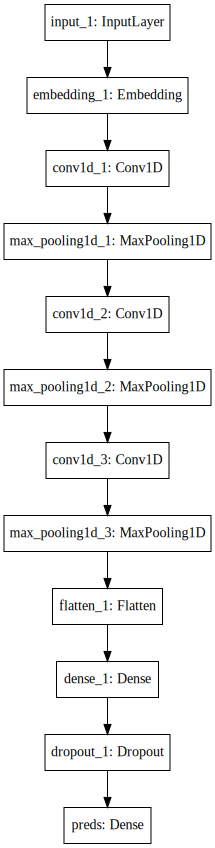

In [9]:
embedding_layer = Embedding(len(word_index) + 1,
                            word_vector_dimensionality,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

inputs = Input(shape=(max_sequence_length,), dtype='int32') # inputs
x      = embedding_layer(inputs) # embedded sequences
x      = Conv1D(128, 5, activation='relu')(x)
x      = MaxPooling1D(5)(x) 
x      = Conv1D(128, 5, activation='relu')(x) 
x      = MaxPooling1D(5)(x) 
x      = Conv1D(128, 5, activation='relu')(x) 
x      = MaxPooling1D(35)(x) # global max pooling
x      = Flatten()(x)
x      = Dense(300, activation='relu')(x)
x      = Dropout(rate=0.5)(x)
preds  = Dense(2, activation='softmax', name='preds')(x)
model  = Model(input=inputs, output=preds)
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['acc'])
summary_and_diagram(model)

In [10]:
%%time
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=60, batch_size=32, verbose=False)

CPU times: user 18min 12s, sys: 53.3 s, total: 19min 5s
Wall time: 2min 41s


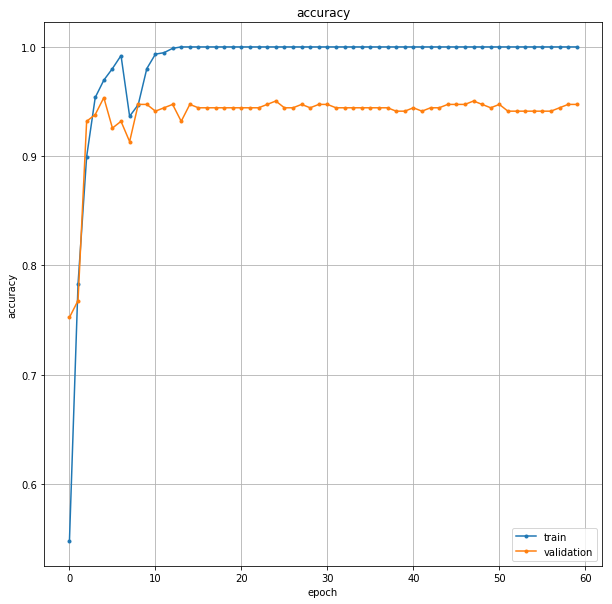

max. validation accuracy observed: 0.9535603715170279
max. validation accuracy history index: 4


In [11]:
model_training_plot(history)
print(f'max. validation accuracy observed: {max(model.history.history["val_acc"])}')
print(f'max. validation accuracy history index: {model.history.history["val_acc"].index(max(model.history.history["val_acc"]))}')

# model: convolutional neural network with multiple towers of varying kernel sizes

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 100)    2003100     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 128)     38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 997, 128)     51328       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

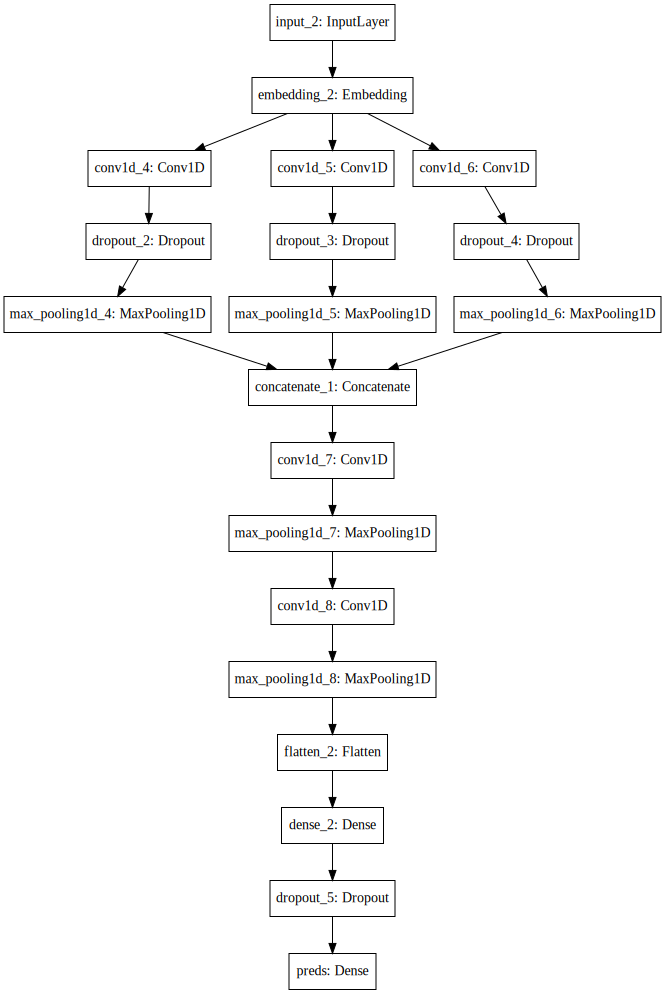

In [12]:
embedding_layer = Embedding(len(word_index) + 1,
                            word_vector_dimensionality,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

inputs = Input(shape=(max_sequence_length,), dtype='int32') 
x = embedding_layer(inputs)

convolutional_layer_towers = [] 
for kernel_size in [3, 4, 5]:
    _x = Conv1D(filters=128, kernel_size=kernel_size, activation='relu')(x)
    _x = Dropout(rate=0.1)(_x)
    _x = MaxPooling1D(5)(_x)
    convolutional_layer_towers.append(_x)
x     = Concatenate(axis=1)(convolutional_layer_towers)
x     = Conv1D(128, 5, activation='relu')(x) 
x     = MaxPooling1D(5)(x) 
x     = Conv1D(128, 5, activation='relu')(x) 
x     = MaxPooling1D(30)(x) 
x     = Flatten()(x) 
x     = Dense(128, activation='relu')(x)
x     = Dropout(rate=0.5)(x)
preds = Dense(2, activation='softmax', name='preds')(x)
model = Model(input=inputs, output=preds)
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['acc'])
summary_and_diagram(model)

In [13]:
%%time
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=100, batch_size=32, verbose=False)

CPU times: user 1h 30min 55s, sys: 4min 39s, total: 1h 35min 35s
Wall time: 13min 1s


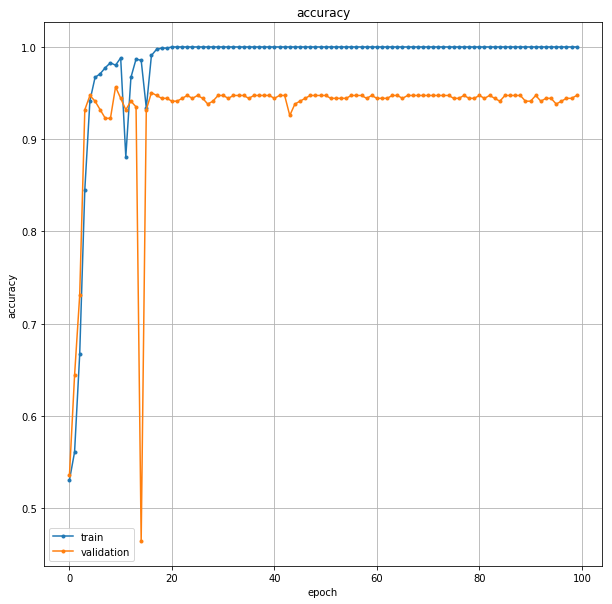

max. validation accuracy observed: 0.9566563467492261
max. validation accuracy history index: 9


In [14]:
model_training_plot(history)
print(f'max. validation accuracy observed: {max(model.history.history["val_acc"])}')
print(f'max. validation accuracy history index: {model.history.history["val_acc"].index(max(model.history.history["val_acc"]))}')